#### Оценить возраст человека по изображению. 

Cоздадим датафрейм содержащий относительный путь к изображению и целевую метку с возрастом

Решить задачу с использованием механизма внимания (слой MultiheadAttention) 

In [25]:
import os
import sys
import wget
import shutil
import tarfile

import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MultiHeadAttention, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

print('OpenCV version ' + cv2.__version__)

OpenCV version 4.8.0


In [2]:
DATA_FOLDER = 'wiki_crop'

Выполним загрузку, проверку и обработку набора изображений из файлов

In [3]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Набор обработаных изображений для оценки возраста
cropped_images = pd.DataFrame(columns=['file_path', 'label'])

# Удалить каталог со старыми обработанными изображеним если существует, если нет - создать
if os.path.exists(os.path.join(DATA_FOLDER, 'cropped')):
    shutil.rmtree(os.path.join(DATA_FOLDER, 'cropped'), ignore_errors=True)

os.makedirs(os.path.join(DATA_FOLDER, 'cropped'))

IMG_SIZE = 64

img_valid=0 #счетчик всех корректных изображений
img_misloaded=0 #счетчик изображений с ошибками при загрузке
img_too_small=0 #счетчик изображений некорректного размера (1х1)
img_bad_faces=0 #счетчик изображений без лиц
img_bad_label=0 #счетчик изображений с некорретной оценкой класса

# Перебор всех вложенных элементов в указаном каталоге
for dir in tqdm(os.listdir(DATA_FOLDER)):
    # если вложенный элемент - каталог
    if os.path.isdir(os.path.join(DATA_FOLDER, dir)):
        # Перебор всех файлов в каталоге
        for file in os.listdir(os.path.join(DATA_FOLDER, dir)):
            try:
                source_file_path = os.path.join(DATA_FOLDER, dir, file)

                # загрузить изображение и сконвертировать в монохромное
                img = Image.open(source_file_path).convert('L')
                img_array = np.array(img)

                # получить параметры изображения
                h, w = img_array.shape[:2]

                # если размер изображения меньше заданного - пропускаем
                if w < 128:
                    img_too_small+=1 
                    continue

                # выполняем детекцию лиц с максимально строгими настройками и минимальным размером лица 64х64
                face_rects1 = face_detector.detectMultiScale(img_array, scaleFactor=1.3, minNeighbors=6, minSize=(64,64))

                # оставляем только фото на которых есть только 1 лицо, остальные - пропускаем
                if len(face_rects1) != 1:
                    img_bad_faces+=1
                    continue  

               
    
                # формируем целевую метку изображения, как разность между вторым и первым годами в наименовании файла
                year_matched = re.findall(r'_(\d{4})', file)
                try:
                    label = int(year_matched[1]) - int(year_matched[0])
                except:
                    label = -1 
                
                # оставляем только изображения к меткой из заданного диапазона
                if (label < 1) | (label > 100):
                    img_bad_label+=1
                    continue

                # выполняем обрезку изображения по контуру лица и приведение к требуемому размеру
                x,y,h,w = face_rects1[0]   
                img = img.crop((x, y, x+w, y+h)).resize((IMG_SIZE,IMG_SIZE), resample=Image.BILINEAR)

                # сохраняем обрезанное изображение в файл
                cropped_file_path = os.path.join(DATA_FOLDER, 'cropped', file)
                #cropped_images = cropped_images.append({'file_path': cropped_file_path, 'label': label}, ignore_index=True)
                cropped_images = pd.concat([cropped_images, pd.DataFrame([{'file_path': cropped_file_path, 'label': label}])], ignore_index=True)
                img.save(cropped_file_path)
                
                
            except Exception as ex:
                #print(ex)
                img_misloaded+=1
                print(ex)
                None # Если файл не удается прочитать - пропускаем его

print(f'Изображений с ошибками при загрузке {img_misloaded}')
print(f'Изображений с некорректными размерами {img_too_small}')
print(f'Изображений на которых не найдены лица {img_bad_faces}')
print(f'Изображений c некорректной меткой класса {img_bad_label}')

print(f'Всего корректных изображений {cropped_images.shape[0]}')

# Сохранить результат обработки данных в CSV-файл
cropped_images.to_csv('imdb_crops.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [11:04<00:00,  6.51s/it]

Изображений с ошибками при загрузке 0
Изображений с некорректными размерами 40182
Изображений на которых не найдены лица 22121
Изображений c некорректной меткой класса 25
Всего корректных изображений 23656


In [4]:
cropped_images

,file_path,label
0,wiki_crop\cropped\10049200_1891-09-16_1958.jpg,67
1,wiki_crop\cropped\10110600_1985-09-17_2012.jpg,27
2,wiki_crop\cropped\1013900_1917-10-15_1960.jpg,43
3,wiki_crop\cropped\10166400_1960-03-12_2008.jpg,48
4,wiki_crop\cropped\10292500_1984-03-26_2009.jpg,25
...,...,...
23651,wiki_crop\cropped\9545499_1912-10-22_1967.jpg,55
23652,wiki_crop\cropped\9557299_1985-03-15_2012.jpg,27
23653,wiki_crop\cropped\961599_1950-01-12_2009.jpg,59
23654,wiki_crop\cropped\9799_1960-06-22_2012.jpg,52


Отобразим произвольные 40 файлов изображений из набора обработанных данных

<AxesSubplot:>

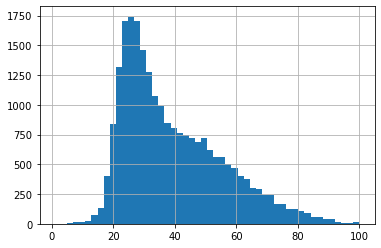

In [5]:
cropped_images['label'].hist(bins=50)

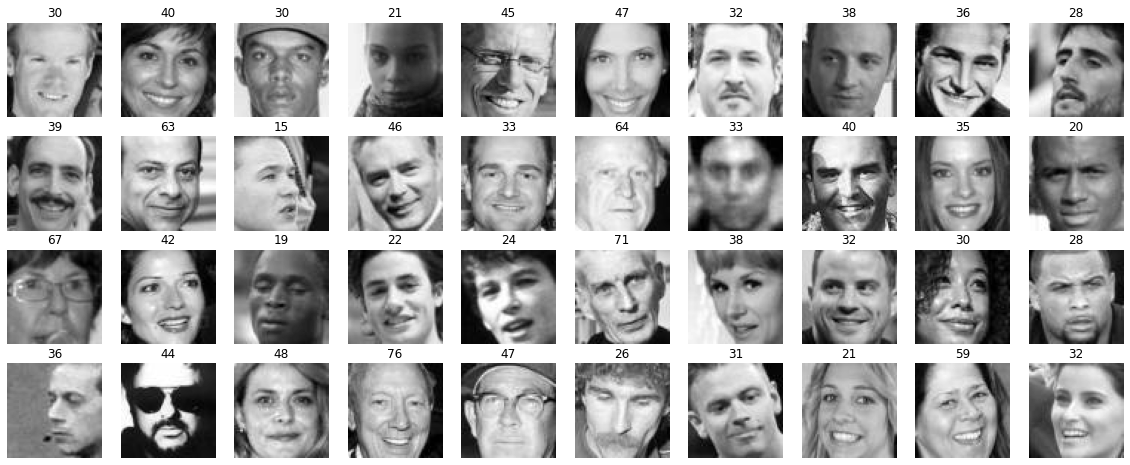

In [6]:
df = cropped_images
fig, ax = plt.subplots(4, 10, figsize=(20, 8))

for i in range(4):
    for j in range(10):
        idx = np.random.choice(range(df.shape[0]))
        file, label = df.iloc[idx].file_path, df.iloc[idx].label
        ax[i, j].imshow(plt.imread(file), cmap='gray')
        ax[i, j].set_title(label)
        ax[i, j].axis('off')

In [7]:
cropped_images.head()

,file_path,label
0,wiki_crop\cropped\10049200_1891-09-16_1958.jpg,67
1,wiki_crop\cropped\10110600_1985-09-17_2012.jpg,27
2,wiki_crop\cropped\1013900_1917-10-15_1960.jpg,43
3,wiki_crop\cropped\10166400_1960-03-12_2008.jpg,48
4,wiki_crop\cropped\10292500_1984-03-26_2009.jpg,25


In [8]:
cropped_images['label'] = cropped_images['label'].astype(np.int32)

In [9]:
train, test = train_test_split(cropped_images, test_size=0.2, random_state=42)

In [10]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [11]:
TARGET_SIZE = (64,64)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="file_path",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

Found 13247 validated image filenames.
Found 5677 validated image filenames.
Found 4732 validated image filenames.


Напишем модель с использованием MultiHeadAttention слоя

In [23]:
input_shape=(64, 64, 3)

input_layer = Input(shape=input_shape)
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer) 
x = MaxPooling2D(2,2)(x)

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) 
x = MaxPooling2D(2,2)(x)

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) 
x = MaxPooling2D(2,2)(x)

x = Dense(128, activation='relu')(x)

attention = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
x = Dropout(0.3)(attention)
x = Flatten()(x)
output_layer = Dense(1, activation='linear')(x)

In [26]:
model = Model(inputs=input_layer, outputs=output_layer)

In [27]:
model.compile(loss='mean_squared_error', optimizer='adam')

Выведим структуру нашей модели

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_25 (Conv2D)             (None, 62, 62, 32)   896         ['input_9[0][0]']                
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 31, 31, 32)  0           ['conv2d_25[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 29, 29, 64)   18496       ['max_pooling2d_24[0][0]']   

In [29]:
history = model.fit_generator(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10
414/414 [==============================] - 79s 184ms/step - loss: 320.9471 - val_loss: 275.2230
Epoch 2/10
414/414 [==============================] - 126s 306ms/step - loss: 271.5612 - val_loss: 271.5410
Epoch 3/10
414/414 [==============================] - 80s 194ms/step - loss: 261.3818 - val_loss: 258.8916
Epoch 4/10
414/414 [==============================] - 83s 200ms/step - loss: 243.9351 - val_loss: 246.0068
Epoch 5/10
414/414 [==============================] - 84s 202ms/step - loss: 226.1172 - val_loss: 214.0043
Epoch 6/10
414/414 [==============================] - 79s 191ms/step - loss: 207.9348 - val_loss: 232.9223
Epoch 7/10
414/414 [==============================] - 78s 188ms/step - loss: 197.1035 - val_loss: 186.6388
Epoch 8/10
414/414 [==============================] - 83s 201ms/step - loss: 188.8389 - val_loss: 182.9050
Epoch 9/10
414/414 [==============================] - 83s 201ms/step - loss: 172.7825 - val_loss: 179.2065
Epoch 10/10
414/414 [===============

In [30]:
test_loss = model.evaluate(test_generator)

148/148 [==============================] - 8s 56ms/step - loss: 175.8309
